In [16]:
import torch
import numpy as np
import gym
from collections import deque, namedtuple
import random
from matplotlib import pyplot as plt
import numpy as np
import copy
from tictactoe_gym.envs.tictactoe_env import TicTacToeEnv

In [17]:
# turns a 3x3 state into a 6 x 3 x 3 state
# 0: player 1
# 1: player 2
# 2: turn
# 3: invalid moves
# 4: empty
# 5: game is over
class EmbedTurnWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(6, 3, 3), dtype=np.int8)
        
    def step(self, action):
        state, reward, done, truncated, info = super().step(action)
        real_state = self._create_state(state, info, done)
        return real_state, reward, done, truncated, info

    def reset(self):
        state, info = super().reset()
        real_state = self._create_state(state, info, False)
        return real_state, info
    
    def _create_state(self, state, info, done):
        side = info['player']
        real_state = np.zeros((6, 3, 3), dtype=np.int8)
        
        real_state[0] = state == 1
        real_state[1] = state == -1
        real_state[2] = side
        real_state[3] = state != 0
        real_state[4] = 0
        real_state[5] = done
        
        return real_state

In [18]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, input_dims, n_filters):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(input_dims, n_filters, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(n_filters),
            torch.nn.ReLU(),
            torch.nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(n_filters),
            torch.nn.ReLU(),
        )
        self.shortcut = torch.nn.Sequential(
            torch.nn.Conv2d(input_dims, n_filters, kernel_size=1, stride=1),
            torch.nn.BatchNorm2d(n_filters),
        )
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        return self.relu(self.layers(x) + self.shortcut(x))


class DNN(torch.nn.Module):
    def __init__(self, board_size, input_dims):
        super().__init__()
        n_filters = 4
        
        self.main_path = torch.nn.Sequential(
            torch.nn.Conv2d(input_dims[0], n_filters, kernel_size=3, stride=1),
            torch.nn.BatchNorm2d(n_filters),
            torch.nn.ReLU(),
            ResidualBlock(n_filters, n_filters),
            ResidualBlock(n_filters, n_filters),
        )
        
        
        self.policy = torch.nn.Sequential(
            torch.nn.Conv2d(n_filters, 2, kernel_size=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear((board_size-2)**2 * 2, board_size ** 2),
            torch.nn.Softmax(dim=1),
        )
        
        self.value = torch.nn.Sequential(
            torch.nn.Conv2d(n_filters, 1, kernel_size=1, stride=1),
            torch.nn.BatchNorm2d(1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear((board_size-2)**2, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1),
            torch.nn.Tanh(),
        )
        
    def forward(self, state):
        x = self.main_path(state)
        policy = self.policy(x)
        value = self.value(x)
        return policy, value
        

In [19]:

class MCTSNode:
    def __init__(self, state, parent=None, prior_action=-1, path_str=""):
        self.path_str = path_str
        size = state.shape[1] * state.shape[2]
        self.state = state
        self.valid_actions = (1-state[3].flatten()).bool()

        self.visit_counts = torch.zeros(size, dtype=torch.int32)
        self.total_action_values = torch.zeros(size, dtype=torch.float32)
        self.mean_action_values = torch.zeros(size, dtype=torch.float32)
        self.prior_probabilities = torch.zeros(size, dtype=torch.float32)
        
        self.selected_count = 0
        self.children = [None] * size
        
        self.parent = parent
        self.prior_action = prior_action
        
    def select(self, puct_multiplier=1.0):        
        const_part = puct_multiplier * np.sqrt(self.selected_count)
        us = const_part * self.prior_probabilities / (1 + self.visit_counts)
        
        sums = self.mean_action_values + us
        invalid_value = torch.min(sums) - 1
        masked_sums = torch.where(self.valid_actions, sums, invalid_value)
        max_a = torch.argmax(masked_sums)
        
        return max_a, self.children[max_a]

    def __repr__(self):
        return f"MCTSNode({self.path_str})"

class MCTS:
    def __init__(self, state, evaluator, path_str=""):
        self.root = MCTSNode(state, path_str=path_str)
        self.PUCT_CONST = 1
        self.tau = 1
        
        # dihedral transforms on the board
        self.dihedrals_transforms = [
            lambda x: x,
            lambda x: torch.rot90(x, k=1, dims=(1, 2)),
            lambda x: torch.rot90(x, k=2, dims=(1, 2)),
            lambda x: torch.rot90(x, k=3, dims=(1, 2)),
            lambda x: torch.flip(x, dims=(1,)),
            lambda x: torch.flip(x, dims=(2,)),
            lambda x: torch.flip(torch.rot90(x, k=1, dims=(1, 2)), dims=(1,)),
            lambda x: torch.flip(torch.rot90(x, k=1, dims=(1, 2)), dims=(2,)),
        ]
        
        self.evaluator = evaluator
        
    
    def train(self, env, state):        
        state, parent, child, action, value, done = self.search(env, self.root)
        if not child:
            child, evalue = self.expand(state, parent, action)
            if not done:
                self.backup(child, evalue)
                return

        self.backup(child, value)
                
    def search(self, env, root):
        node = root
        cnode = root
        state = None
        done = False
        value = None
        while cnode and not done:
            node = cnode
            action, cnode = node.select(self.PUCT_CONST)
            state, reward, done, _, info = env.step(action.item())
            state = torch.tensor(state, dtype=torch.float32)
            
            side = info['player']
            
            if done:
                value = reward * side
        
        return state, node, cnode, action, value, done
    
    def expand(self, state, parent, action):
        # select a random dihedral transform
        t = self.dihedrals_transforms[random.randint(0, 7)]
        tstate = t(state).unsqueeze(0)
        
        self.evaluator.eval()
        policy, value = self.evaluator(tstate)
        self.evaluator.train()
        
        policy = policy.mean(dim=0)
        value = value.mean()
        
        child = MCTSNode(state, parent=parent, prior_action=action, path_str=parent.path_str + str(action.item()))
        parent.children[action] = child
        child.prior_probabilities = policy
        
        return child, value
        
    def backup(self, child, value):
        child = child
        parent = child.parent
        while parent:
            parent.selected_count += 1
            parent.visit_counts[child.prior_action] += 1
            parent.total_action_values[child.prior_action] += value
            parent.mean_action_values[child.prior_action] = parent.total_action_values[child.prior_action] / parent.visit_counts[child.prior_action]
            
            value = -value
            child, parent = parent, parent.parent
            
    
    # given parent state, returns the child action        
    def play(self, state, deterministic=False):
        node = self.root
        pis = (node.visit_counts ** (1 / self.tau)) / (node.selected_count ** (1 / self.tau))
        if deterministic:
            selected_action = torch.argmax(pis).item()
        else:
            selected_action = torch.multinomial(pis, 1).item()

        child = node.children[selected_action]
        child.parent = None
        self.root = child
        return selected_action
    
    # given an action play it and updates the tree with the new child state
    def play_user_move(self, action, state):
        if not self.root.children[action]:
            # the user made a move that was not in the tree
            # we need to expand the tree
            parent = self.root
            state = state
            child, value = self.expand(state, parent, action)
        
        child = self.root.children[action]
        child.parent = None
        self.root = child
        
        
        
        

In [20]:
Experience = namedtuple('Experience', 'state policy outcome')

In [21]:
class AlphaGoZero:
    def __init__(self, env):
        self.env = env
        self.board_size = 3
        
        self.max_moves = self.env.action_space.n
        
        self.batch_size = 16
        self.min_buffer_size = 16
                
        input_dims = env.observation_space.shape

        base_state, info = env.reset()
        base_state = torch.tensor(base_state, dtype=torch.float32)
        self.dnn = DNN(self.board_size, input_dims)
        self.mcts = MCTS(base_state, self.dnn)
        self.trojectory_buffer = deque(maxlen=10000)
        
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=0.001)
        
    def reset(self):
        base_state, info = self.env.reset()
        base_state = torch.tensor(base_state, dtype=torch.float32)
        self.mcts = MCTS(base_state, self.dnn)
        return base_state, info
        
    def train(self, iterations, sub_iterations, render=False, eval=False, deterministic=False):
        losses = []
        for i in range(iterations):

            state, info = self.reset()
            state = torch.tensor(state, dtype=torch.float32)
            done = False
        
            step_n = 0
            pending_trojectory = []
            print("Iteration: ", i)
            while not done and step_n <= self.max_moves:
                side = info["player"]
                if render:
                    print("Iteration: ", i, "Step: ", step_n, " Side: ", "P1" if side == 1 else "P2")

                for _ in range(sub_iterations):
                    env2 = copy.deepcopy(self.env)               
                    self.mcts.train(env2, state)
                    env2.close()
                
                # print(self.mcts.root.visit_counts)
                action = self.mcts.play(state, deterministic=deterministic)
                nstate, reward, done, _, info = self.env.step(action)
                nstate = torch.tensor(nstate, dtype=torch.float32)
                if render:
                    self.env.render()
                
                pending_trojectory.append((state, action))
                state = nstate
                
                step_n += 1                    
                    
            if not eval:
                for (state, action) in reversed(pending_trojectory):
                    self.trojectory_buffer.append(Experience(state, action, reward * side))
                    side *= -1
                if len(self.trojectory_buffer) >= self.min_buffer_size:
                        loss = self.train_dnn()
                        losses.append(loss)
                
        return losses
    
    def play_against_player(self, player_side):
        state, info = self.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        self.env.render()
        
        for i in range(self.max_moves):
            print("Turn: ", i)
            if info["player"] == player_side:
                print("User is thinking...")
                action = int(input("Enter action: "))
                state, reward, done, _, info = self.env.step(action)
                state = torch.tensor(state, dtype=torch.float32)
                action = torch.tensor(action, dtype=torch.long)
                self.mcts.play_user_move(action, state)
                self.env.render()
                print("", flush=True)
                
            else:
                # run the MCTS
                print("Agent is thinking...")
                for _ in range(100):
                    env2 = copy.deepcopy(self.env)  
                    self.mcts.train(env2, state)
                    env2.close()

                action = self.mcts.play(state, deterministic=False)
                state, reward, done, _, info = self.env.step(action)
                state = torch.tensor(state, dtype=torch.float32)
                self.env.render()
                print("", flush=True)
            if done:
                break
        
        return reward   
    
    def train_dnn(self):
        batches = random.sample(self.trojectory_buffer, self.batch_size)
        states, policies, outcomes = zip(*batches)
        states = torch.stack(states).detach()
        policies = torch.tensor(policies, dtype=torch.long).detach()
        outcomes = torch.tensor(outcomes, dtype=torch.float32).detach()
        
        predicted_policies, predicted_values = self.dnn(states)
        
        value_loss = torch.nn.functional.mse_loss(predicted_values.squeeze(-1), outcomes)
        policy_loss = torch.nn.functional.cross_entropy(predicted_policies, policies)
        total_loss = value_loss + policy_loss

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        
        return value_loss.item(), policy_loss.item(), total_loss.item()
         

In [22]:
env = EmbedTurnWrapper(TicTacToeEnv())
alphago_zero = AlphaGoZero(env)
losses = alphago_zero.train(256, 16)


C:\Users\Unevilicorn\AppData\Local\Temp\ipykernel_1156\3507121624.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)


Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Itera

In [26]:
alphago_zero.play_against_player(1)


C:\Users\Unevilicorn\AppData\Local\Temp\ipykernel_1156\3507121624.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)


...
...
...

Turn:  0
User is thinking...
...
..X
...


Turn:  1
Agent is thinking...
.O.
..X
...


Turn:  2
User is thinking...
.O.
.XX
...


Turn:  3
Agent is thinking...
.O.
.XX
.O.


Turn:  4
User is thinking...
.O.
XXX
.O.




1.0

In [24]:
alphago_zero.train(1, 256, render=True, eval=True)

C:\Users\Unevilicorn\AppData\Local\Temp\ipykernel_1156\3507121624.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)


Iteration:  0
Iteration:  0 Step:  0  Side:  P1
...
X..
...

Iteration:  0 Step:  1  Side:  P2
...
XO.
...

Iteration:  0 Step:  2  Side:  P1
X..
XO.
...

Iteration:  0 Step:  3  Side:  P2
X..
XO.
O..

Iteration:  0 Step:  4  Side:  P1
X.X
XO.
O..

Iteration:  0 Step:  5  Side:  P2
XOX
XO.
O..

Iteration:  0 Step:  6  Side:  P1
XOX
XO.
OX.

Iteration:  0 Step:  7  Side:  P2
XOX
XOO
OX.

Iteration:  0 Step:  8  Side:  P1
XOX
XOO
OXX



[]

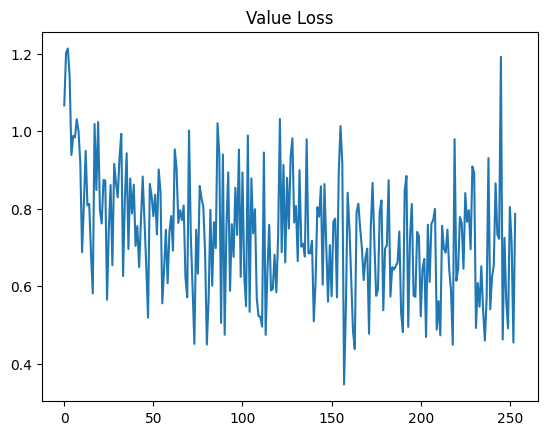

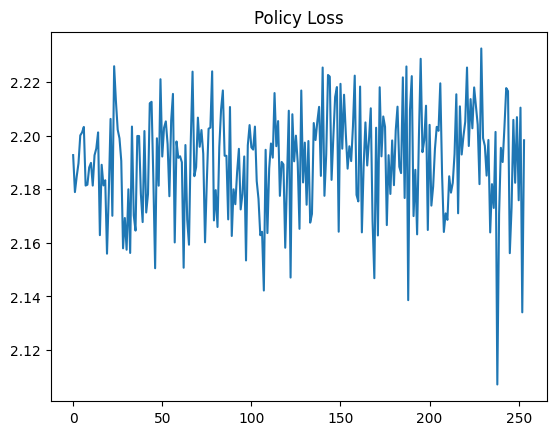

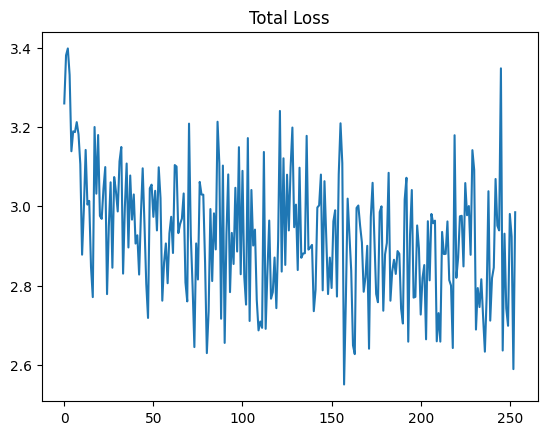

In [25]:
# plot losses
value_losses, policy_losses, total_losses = zip(*losses)


plt.plot(value_losses)
plt.title("Value Loss")
plt.show()
plt.plot(policy_losses)
plt.title("Policy Loss")
plt.show()
plt.plot(total_losses)
plt.title("Total Loss")
plt.show()
